# Rasterizing vectors & vectorizing rasters <img align="right" src="../Supplementary_data/dea_logo.jpg">

* [**Sign up to the DEA Sandbox**](/setup/sandbox.html) to run this notebook interactively from a browser
* **Compatibility:** Notebook currently compatible with both the `NCI` and `DEA Sandbox` environments
* **Products used:** 
[ga_ls_wo_fq_cyear_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls_wo_fq_cyear_3)

## Background

Many remote sensing and/or geospatial workflows require converting between vector data (e.g. shapefiles) and raster data (e.g. pixel-based data like that in an `xarray.DataArray`).
For example, we may need to use a shapefile as a mask to limit the analysis extent of a raster, or have raster data that we want to convert into vector data to allow for easy geometry operations.

## Description
This notebook demonstrates the use of the DEA function `xr_rasterize` and `xr_vectorize` from [dea_tools.spatial](../Tools/dea_tools/spatial.py). 

The first section loads in [DEA Water Observations Statistics](/data-products/dea/686/dea-water-observations-statistics-landsat) data from Digital Earth Australia, and vectorises the pixel-based `xarray.DataArray` object into a vector-based `geopandas.GeoDataFrame` object containing persistent water-bodies as polygons. 
We then export the `GeoDataframe` as a vector file.  

The second section rasterises the vector data we created in the first section back into an `xarray.DataArray`, and exports the results as a GeoTIFF.

## Getting started
To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages


In [1]:
import datacube
import matplotlib.pyplot as plt

import sys
sys.path.insert(1, '../Tools/')
from dea_tools.spatial import xr_vectorize, xr_rasterize


### Connect to the datacube

In [2]:
dc = datacube.Datacube(app='Rasterize_vectorize')

## Load DEA Water Observations data from the datacube

We will load in an annual summary from the [DEA Water Observations Statistics](/data-products/dea/686/dea-water-observations-statistics-landsat) product to provide us with some data to work with. The query below will load the 2000 annual summary of DEA Water Observations product for a region around the Menindee Lakes.

In [3]:
# Create a query object
query = {
    'x': (142.1, 142.80),
    'y': (-32.1, -32.6),
    'time': ('2000')
}

# Load WoFS through the datacube
ds = dc.load(product='ga_ls_wo_fq_cyear_3', 
             **query)
ds


<xarray.Dataset>
Dimensions:      (time: 1, y: 2037, x: 2324)
Coordinates:
  * time         (time) datetime64[ns] 2000-07-01T23:59:59.999999
  * y            (y) float64 -3.536e+06 -3.536e+06 ... -3.597e+06 -3.597e+06
  * x            (x) float64 9.396e+05 9.396e+05 ... 1.009e+06 1.009e+06
    spatial_ref  int32 3577
Data variables:
    count_wet    (time, y, x) int16 0 0 0 0 0 0 0 0 0 1 ... 0 0 0 0 0 0 0 0 0 0
    count_clear  (time, y, x) int16 29 29 29 29 29 29 29 ... 14 14 14 14 14 14
    frequency    (time, y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

### Plot the DEA Water Observations data

Let's plot the DEA Water Observations data to get an idea of the objects we will be transforming. 
In the code below, we first select the pixels where the satellite has observed water at least 25% of the year, this is so we can isolate the more persistent water bodies and reduce some of the noise before we vectorize the raster.

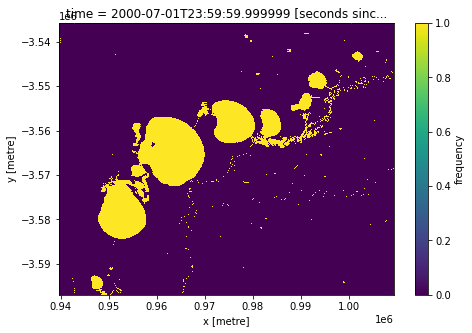

In [4]:
# Select pixels that are classified as water > 25 % of the time
water_bodies = ds.frequency > 0.25

# Plot the data
water_bodies.plot(size=5)

## Vectorizing an `xarray.DataArray`

To convert our `xarray.DataArray` object into a vector based `geopandas.GeoDataFrame`, we can use the DEA function `xr_vectorize` from [dea_tools.spatial](../Tools/dea_tools/spatial.py). 
This tool is based on the [rasterio.features.shape](https://rasterio.readthedocs.io/en/stable/api/rasterio.features.html) function, and can accept any of the arguments in `rasterio.features.shape` using the same syntax.

In the cell below, we use the argument `mask=water_bodies.values==1` to indicate we only want to convert the values in the xarray object that are equal to 1.

In [5]:
gdf = xr_vectorize(da=water_bodies,
                   mask=water_bodies.values == 1)

### Plot our vectorised raster 

<AxesSubplot:>

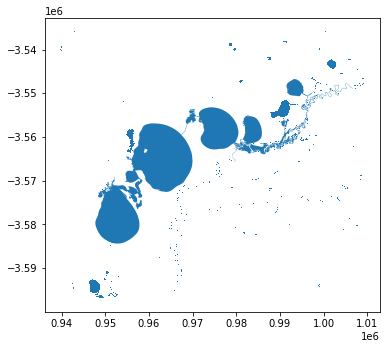

In [6]:
gdf.plot(figsize=(6, 6))

### Export as vector file

The `xr_vectorize` function also allows us to very easily export the `GeoDataFrame` as a vector file for use in other applications using the `output_path` parameter.
For this example we will export our data as a `GeoJSON` vector file; use the extension `.shp` to export an ESRI Shapefile instead.

In [7]:
gdf = xr_vectorize(da=water_bodies,
                   mask=water_bodies.values == 1,
                   output_path='test.geojson')

Exporting vector data to test.geojson


***
## Rasterizing a vector file

Using the `xr_rasterize` function from [`dea_tools.spatial`](../Tools/dea_tools/spatial.py), we can "rasterize" our `geopandas.GeoDataFrame` back into a `xarray.DataArray`.
This function uses an existing `xarray.DataArray` object as a template for converting our vector into a raster object (the template provides the size, CRS, dimensions, and attributes of the output array).

As we already have the `GeoDataFrame` loaded we don't need to read in our vector file, but if we wanted to read in a vector file first we could use [`gpd.read_file()`](http://geopandas.org/reference/geopandas.read_file.html).   

> **Note:** The `xr_rasterize` function is based on the `rasterio` function [`rasterio.features.rasterize`](https://rasterio.readthedocs.io/en/stable/api/rasterio.features.html), and can accept any arguments supported by `rasterio.features.rasterize`.

In [8]:
water_bodies_again = xr_rasterize(gdf=gdf, da=water_bodies)

We can plot our rasterised `water_bodies_again` data to verify it looks identical to our original `water_bodies` data we loaded from the datacube:

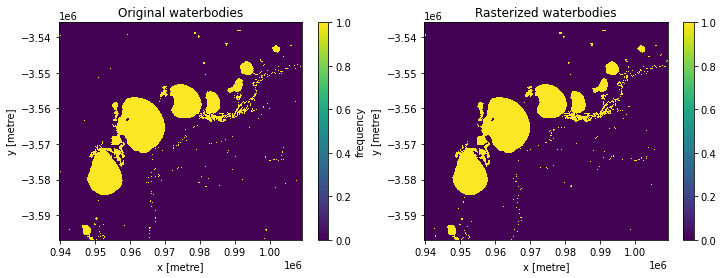

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
water_bodies.plot(ax=axes[0])
water_bodies_again.plot(ax=axes[1])
axes[0].set_title('Original waterbodies')
axes[1].set_title('Rasterized waterbodies');

### Rasterizing attribute values
In the previous examples, we rasterized our vector data into a simple boolean raster containing 1s and 0s. 
We can however also use a specific attribute column in our vector data as values that will be assigned to each of our raster pixels.

For example, we can modify our vectorised data to give each polygon a unique number in the 'attribute' column:

In [10]:
gdf['attribute'] = gdf.index
gdf

,attribute,geometry
0,0,"POLYGON ((942810.000 -3535830.000, 942810.000 ..."
1,1,"POLYGON ((942930.000 -3535830.000, 942930.000 ..."
2,2,"POLYGON ((943140.000 -3535860.000, 943200.000 ..."
3,3,"POLYGON ((1000410.000 -3535830.000, 1000440.00..."
4,4,"POLYGON ((950550.000 -3536010.000, 950550.000 ..."
...,...,...
1293,1293,"POLYGON ((950550.000 -3596790.000, 950550.000 ..."
1294,1294,"POLYGON ((946980.000 -3592680.000, 947190.000 ..."
1295,1295,"POLYGON ((942810.000 -3596670.000, 942840.000 ..."
1296,1296,"POLYGON ((942780.000 -3596910.000, 942780.000 ..."


Now we can rasterize our polygons using the unique values from the 'attribute' column:

In [11]:
water_bodies_attribute = xr_rasterize(gdf=gdf,
                                      da=water_bodies,
                                      attribute_col='attribute')

When we plot this raster data, we can see our rasterized waterbodies now contain pixel values that match the unique values in the 'attribute' column of our vector data:

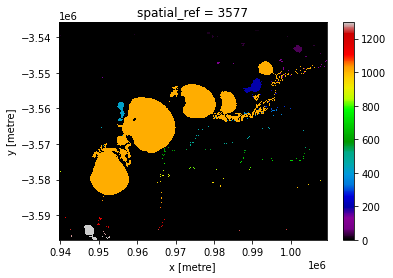

In [12]:
water_bodies_attribute.plot(cmap='nipy_spectral')

### Export rasterized data as a GeoTIFF

`xr_rasterize` also allows us to export our results as a GeoTIFF raster file using the `output_path` parameter:

In [13]:
water_bodies_again = xr_rasterize(gdf=gdf,
                                  da=water_bodies,
                                  output_path='test.tif')


Exporting raster data to test.tif


---

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** November 2022

**Compatible datacube version:** 

In [14]:
print(datacube.__version__)

1.8.6


## Tags
Browse all available tags on the DEA User Guide's [Tags Index](/genindex.html)